In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [2]:
from dateutil.relativedelta import relativedelta

In [3]:
from datetime import date

In [4]:
df_sample = pd.read_csv('../data/raw/sample_submission.csv')
df_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [8]:
df = pd.read_csv('../data/raw/train.csv')
df_copy = df.copy()
tmp = df.copy()
tmp.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# Dataprep exog

In [6]:
df_oil = pd.read_csv('../data/raw/oil.csv')
df_hol = pd.read_csv('../data/raw/holidays_events.csv')
df_tra = pd.read_csv('../data/raw/transactions.csv')
df_sto = pd.read_csv('../data/raw/stores.csv')

In [7]:
df_train.shape

(3000888, 6)

In [8]:
df_train.head(1)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [9]:
df_oil.head(1)

,date,dcoilwtico
0,2013-01-01,NaN


In [10]:
df_hol.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [11]:
df_tra.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [12]:
df_sto.head(1)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [13]:
df = df_train.copy()
df = df.merge(df_oil, on=['date'], how='left')

In [14]:
#Missing de preço de óleo
df.dcoilwtico.isnull().sum()/df.shape[0]

0.30938242280285033

In [15]:
df = df.merge(df_sto, on=['store_nbr'], how='left')

In [16]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13


In [17]:
for nbr in df.store_nbr.unique():
    aux = df.loc[df.store_nbr==20][['city','state']].value_counts().shape[0]
    if aux > 1:
        print (nbr)

In [18]:
# Como seria em SQL?
"""
SELECT
t1.*,
t2.type,
t2.description,
t2.transferred

FROM df AS t1 LEFT JOIN df_hol as t2
ON t1.date = t2.date AND 
((t1.city = t2.locale_name AND t2.locale = 'Local')
OR 
(t1.state = t2.locale_name AND t2.locale = 'Regional'))
"""

"\nSELECT\nt1.*,\nt2.type,\nt2.description,\nt2.transferred\n\nFROM df AS t1 LEFT JOIN df_hol as t2\nON t1.date = t2.date AND \n((t1.city = t2.locale_name AND t2.locale = 'Local')\nOR \n(t1.state = t2.locale_name AND t2.locale = 'Regional'))\n"

In [19]:
#Rename
df_hol = df_hol.rename(columns={'type':'hol_type'})

In [20]:
df = df.merge(df_hol, on=['date'], how='left')

In [21]:
df.locale.unique()

array(['National', nan, 'Local', 'Regional'], dtype=object)

In [22]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'city', 'state', 'type', 'cluster', 'hol_type', 'locale',
       'locale_name', 'description', 'transferred'],
      dtype='object')

In [23]:
df['transferred'] = df.transferred.fillna(False)

In [24]:
df['flag_feriado'] = 1*(((df.locale=='National')
                        |((df.locale=='Local')
                          &(df.city==df.locale_name))
                        |((df.locale=='Regional')
                          &(df.state==df.locale_name)))
                        * (df.transferred==False)
                        * (df.hol_type != 'Work Day'))

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month.
Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016.
People rallied in relief efforts donating water and other first need products
which greatly affected supermarket sales for several weeks after the earthquake.


In [25]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [26]:
df_copy = df.copy()

In [27]:
def last_day(data):
    aux = data + relativedelta(months=1)
    aux = date(aux.year, aux.month, 1)
    aux = aux - relativedelta(days=1)
    return aux.day

def dia_de_pagamento(data):
    if (data.day == 15)|(data.day == last_day(data)):
        return True
    return False

In [28]:
# df['pagamento'] = df.apply(lambda x: dia_de_pagamento(x.date), axis=1)

In [29]:
df['pagamento'] = 1*((df.date.dt.day>=15)&(df.date.dt.day<19))+1*((df.date.dt.day>=1)&(df.date.dt.day<6))

In [30]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,hol_type,locale,locale_name,description,transferred,flag_feriado,pagamento
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1


In [31]:
#Feriados duplicaram

In [32]:
group = df.groupby('id')[['flag_feriado']].max()

In [33]:
df = df.drop_duplicates(subset=['id']).set_index('id')
df['flag_feriado'] = group.flag_feriado

In [34]:
df.shape

(3000888, 17)

In [35]:
df.head(1)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,hol_type,locale,locale_name,description,transferred,flag_feriado,pagamento
id,,,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,1,1


In [36]:
# Retirar sábado e domingo

In [37]:
df.store_nbr.nunique()

54

# Modelagem 1 loja

In [11]:
df.head(1)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


temos várias séries temporais: vendas por loja e por familia.

In [12]:
df.store_nbr.nunique()

54

In [13]:
df.family.nunique()

33

In [136]:
df_agg = df.groupby(['store_nbr', 'date'], as_index=False).sales.sum()
df_agg['date'] = pd.to_datetime(df_agg.date, format='%Y-%m-%d')

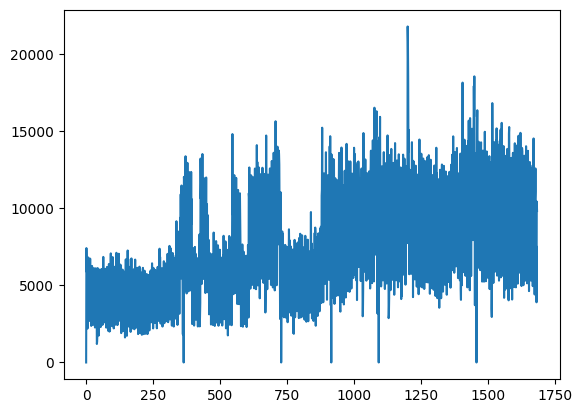

In [137]:
aux = df_agg.loc[df_agg.store_nbr==1]
plt.plot(aux.sales)

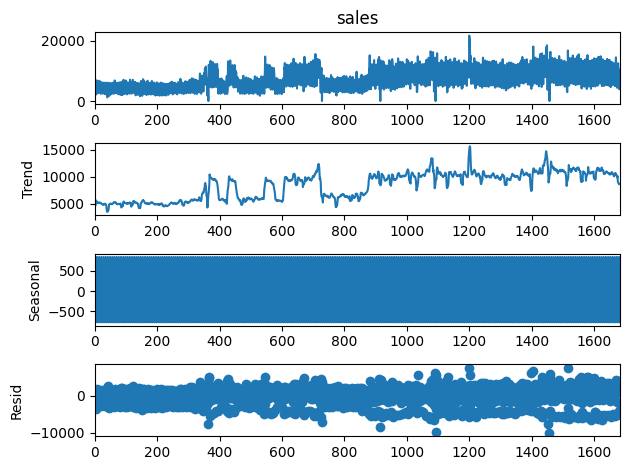

In [138]:
seasonal_decompose(aux.sales, period=7).plot();

## Modelagem

In [313]:
from pmdarima.arima import auto_arima, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from numba import jit

In [108]:
model = ARIMA((1,1,1),(1,0,0,7))

In [167]:
first = 1400
last = 1500
aux_fit = aux.iloc[first:last]
# aux_fit['date'] = aux_fit.date.dt.to_period('D') #add se período interessante
#mas parece ter problema com forecast apontando 1 d a menos
aux_fit = aux_fit.set_index('date')
fit = model.fit(aux_fit.sales)

/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/venv0/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [168]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                -926.418
Date:                            Fri, 07 Apr 2023   AIC                           1862.836
Time:                                    19:44:53   BIC                           1875.811
Sample:                                         0   HQIC                          1868.086
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.5456     24.015      0.314      0.753     -39.523      54.615
ar.L1          0.4366      0.121      3.613      0.000       0.200       0.673
ma.L1         -0.9095      0.069    -13.249      0.000      -1.044      -0.775
ar.S.L7        0.8063      0.059     13.725      0.000       0.691       0.921
sigma2      8.526e+06   2.36e-06   3.62e+12      0.000    8.53e+06    8.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                14.47
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+29. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

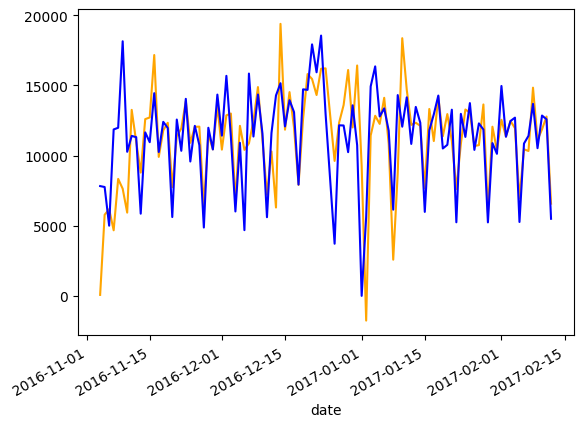

In [169]:
fit.fittedvalues().plot(c='orange')
aux_fit.sales.plot(c='b')

In [170]:
fit.predict(forecast)

/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


100    10514.982046
101    11189.396663
102    13133.795216
103    10641.658891
104    12548.705439
105    12355.818665
106     6653.643961
107    10716.090119
108    11273.921537
109    12855.374584
dtype: float64

/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


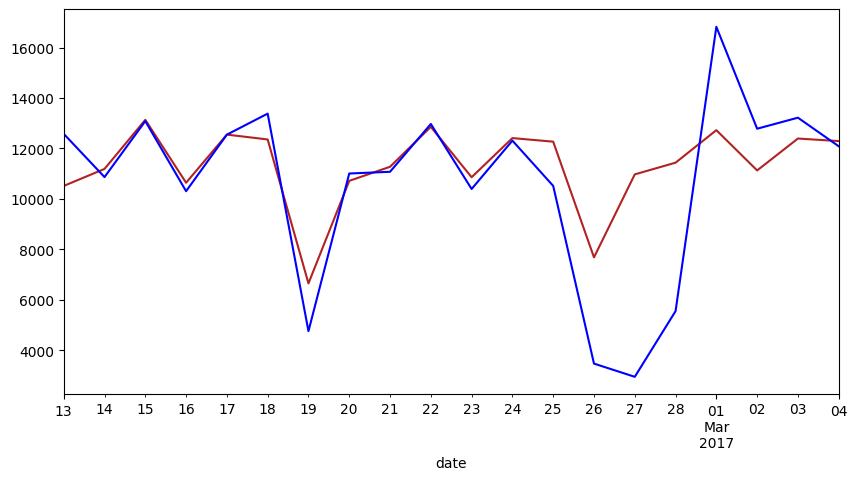

In [172]:
forecast = 20
pred = fit.predict(forecast)
aux_plot = aux.iloc[last:last+forecast]
# aux_plot['date'] = aux_plot.date.dt.to_period('D')
aux_plot = aux_plot.set_index('date')
pred.index = aux_plot.index
pred.plot(c='firebrick', figsize=(10,5))
plt.plot(aux_plot.sales, c='b')

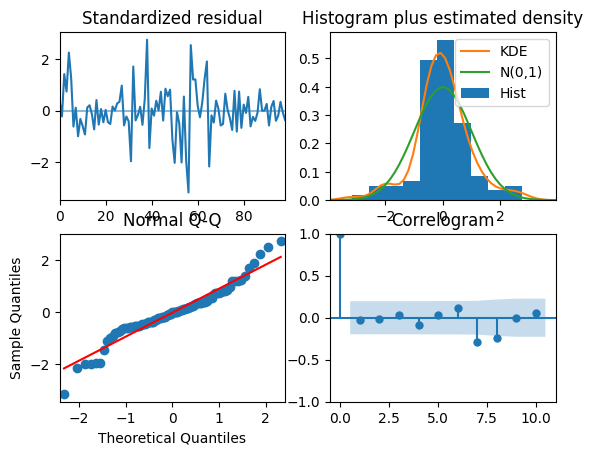

In [173]:
fit.plot_diagnostics();

## Função para ajuste e predict para multiplas séries

In [251]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm

## Agrupando por loja

In [179]:
#Pivotando a df para cada série ser uma coluna
df_agg = df.groupby(['store_nbr', 'date'], as_index=False).sales.sum()
df_agg['date'] = pd.to_datetime(df_agg.date, format='%Y-%m-%d')
df_pivot = df_agg.pivot_table(values='sales', index='date', columns='store_nbr')

In [167]:
first = 1400
last = 1500
aux_fit = aux.iloc[first:last]
# aux_fit['date'] = aux_fit.date.dt.to_period('D') #add se período interessante
#mas parece ter problema com forecast apontando 1 d a menos
aux_fit = aux_fit.set_index('date')
fit = model.fit(aux_fit.sales)

/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/venv0/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/venv0/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [259]:
import warnings
warnings.filterwarnings('ignore')
first = 1000
last = 1100
forecast = 10
aux_pivot = df_pivot.iloc[first:last]
erros = []
predicts = []
tests = []
modelo = ARIMA((1,1,1),(1,0,0,7), method='powell')
for col in tqdm(aux_pivot.columns):
#     print(f'ajustando série {col}...')
    fit = modelo.fit(aux_pivot[col])
    pred = fit.predict(forecast)
    predicts.append(pred)
    aux_test = df_pivot.iloc[last:last+forecast][col]
    tests.append(aux_test)
    erro = mape(aux_test, pred)
    erros.append(erro)
#     print(f'mape para série {col} = {erro}')
#     modelos_fitados.append[fit]
warnings.filterwarnings('default')

100%|███████████████████████████████████████████| 54/54 [00:14<00:00,  3.66it/s]


In [277]:
np.mean(erros)

0.25227653950748413

In [ ]:
##

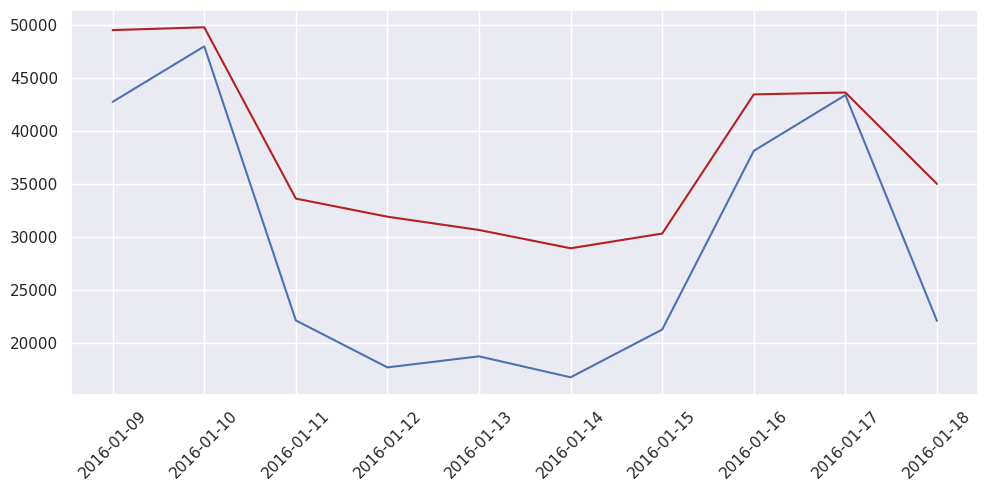

In [276]:
sns.set(rc={'figure.figsize':(11.7,5)})

i = 45

aux_pred = predicts[i]
aux_pred.index = tests[i].index
plt.plot(aux_pred, c='firebrick')
plt.plot(tests[i])
plt.xticks(rotation=45);

## Agrupando por loja e familia de produto

In [279]:
df_pivot = df.pivot_table(values='sales', index='date', columns=['store_nbr','family'])

In [285]:
df_pivot.shape

(1684, 1782)

In [296]:
#Quebra o multiindex
df_pivot.columns = df_pivot.columns.map(lambda x: '_'.join([str(i) for i in x]))

In [298]:
df_pivot.head(1)

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD/BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [318]:
#numba não ajuda com pandas
@jit(nopython=False)
def run_TS_numba(dataframe, dataframe_completa, forecast):
    warnings.filterwarnings('ignore')
    erros = []
    predicts = []
    tests = []
    modelo = ARIMA((1,1,1),(1,0,0,7), method='powell')
    for col in tqdm(dataframe.columns):
        #Checa se há desvio padrão suficiente para justificar modelagem.
        if aux_pivot[col].std() > 2:
            fit = modelo.fit(dataframe[col])
            pred = fit.predict(forecast)
        #Do contrário, assume média.
        else:
            pred = dataframe[col].mean().repeat(forecast)

        predicts.append(pred)
        aux_test = dataframe_completa.iloc[last:last+forecast][col]
        tests.append(aux_test)
        erro = mape(aux_test, pred)
        erros.append(erro)
    #     print(f'mape para série {col} = {erro}')
    #     modelos_fitados.append[fit]

    warnings.filterwarnings('default')
    return predicts, tests, erros

def run_TS(dataframe, dataframe_completa, forecast):
    warnings.filterwarnings('ignore')
    erros = []
    predicts = []
    tests = []
    modelo = ARIMA((1,1,1),(1,0,0,7), method='powell')
    for col in tqdm(dataframe.columns):
        #Checa se há desvio padrão suficiente para justificar modelagem.
        if aux_pivot[col].std() > 1:
            fit = modelo.fit(dataframe[col])
            pred = fit.predict(forecast)
        #Do contrário, assume média.
        else:
            pred = dataframe[col].mean().repeat(forecast)

        predicts.append(pred)
        aux_test = dataframe_completa.iloc[last:last+forecast][col]
        tests.append(aux_test)
        erro = mape(aux_test, pred)
        erros.append(erro)
    #     print(f'mape para série {col} = {erro}')
    #     modelos_fitados.append[fit]

    warnings.filterwarnings('default')
    return predicts, tests, erros



In [319]:
#Teste com numba
first = 1000
last = 1100
forecast = 10
aux_pivot = df_pivot.iloc[first:last]


predicts, tests, erros = run_TS_numba(aux_pivot, df_pivot, 10)

100%|███████████████████████████████████████| 1782/1782 [16:54<00:00,  1.76it/s]


In [328]:
np.mean([erro for erro in erros if erro<100])

0.46980213409845856

In [320]:
np.mean(erros)

3770842213921630.0

In [381]:
#Refatorando para usar arrays
# @jit(nopython=False)
def run_TS_numba(array_train, array_test, forecast):
    warnings.filterwarnings('ignore')
    erros = []
    predicts = []
    tests = []
    modelo = ARIMA((1,1,1),(1,0,0,7), method='powell')
    for col in tqdm(range(array_train.shape[1])):
        #Checa se há desvio padrão suficiente para justificar modelagem.
        if array_train[:,col].std() > 2:
            fit = modelo.fit(array_train[:,col])
            pred = fit.predict(forecast)
        #Do contrário, assume média.
        else:
            pred = array_train[:,col].mean().repeat(forecast)

        predicts.append(pred)
        aux_test = array_test[:,col]
        tests.append(aux_test)
        erro = mape(aux_test, pred)
        erros.append(erro)
    #     print(f'mape para série {col} = {erro}')
    #     modelos_fitados.append[fit]

    warnings.filterwarnings('default')
    return predicts, tests, erros

In [383]:
#Teste com arrays
first = 1000
last = 1100
forecast = 10
array_train = df_pivot.iloc[first:last].values
array_test = df_pivot.iloc[last:last+forecast].values


predicts, tests, erros = run_TS_numba(array_train, array_test, forecast)

100%|███████████████████████████████████████| 1782/1782 [13:49<00:00,  2.15it/s]


In [394]:
pd.DataFrame({'erros':erros})

,erros
0,9.610003e-01
1,0.000000e+00
2,2.332865e+15
3,2.044228e-01
4,0.000000e+00
...,...
1777,4.341082e-01
1778,4.033408e-01
1779,3.130551e-01
1780,4.728780e+14


/home/joao/venv0/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/joao/venv0/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


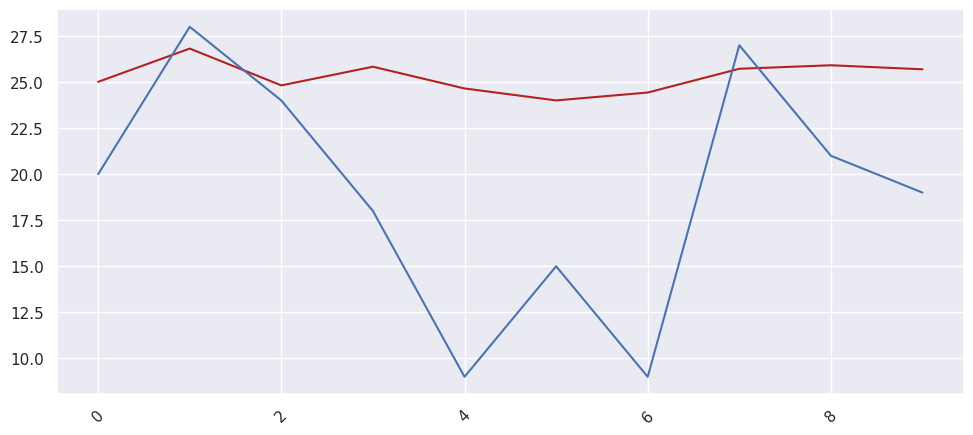

In [396]:
sns.set(rc={'figure.figsize':(11.7,5)})

i = 1333

aux_pred = predicts[i]
plt.plot(aux_pred, c='firebrick')
plt.plot(tests[i])
plt.xticks(rotation=45);

# Classe

In [ ]:
def fit(self, ts):
        """
        Fit the SARIMA model to the given time series data.
        
        Parameters:
        ts (pandas.DataFrame): The time series data to fit the model to.
        
        Returns:
        None
        """
        # list of possible seasonality periods to check
        seasonal_periods = [7, 30, 365]

        # initialize the best score as a very high number
        best_score = np.inf
        best_seasonality = None

        # loop through each possible seasonality period
        for period in seasonal_periods:

            # check for seasonality with this period
            result = sm.tsa.seasonal_decompose(ts, model='additive', period=period)
            seasonal = result.seasonal

            # calculate the score for this period
            score = np.abs(seasonal).mean()

            # if this period has a better score than the previous best score, update the best score and best seasonality
            if score < best_score:
                best_score = score
                best_seasonality = period

        # set the best seasonality period
        self.seasonality = best_seasonality

        # train a SARIMA model with the best seasonality period and the specified order
        self.model = SARIMAX(ts, order=self.order, seasonal_order=(0, 1, 1, self.seasonality)).fit()

In [564]:
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

class SARIMAForecaster:
    """
    A class for fitting and forecasting with a SARIMA model.
    """

    def __init__(self, order=None, seasonal_order=None, test_periods=None, check_variance=False):
        """
        Initialize the SARIMAForecaster.

        Parameters:
        - order: tuple (p, d, q) of int
            The non-seasonal (ARIMA) order.
        - seasonal_order: tuple (P, D, Q) of int
            The seasonal (SARIMA) order.
        - test_periods: list of int
            The periods to test
        - check_variance: bool
            If true, checks if the time series has enough variance
            to justify modelling.
        """
        self.order = order
        self.seasonal_order = seasonal_order
        self.test_periods = test_periods
        self.check_variance = check_variance
        self.model = None
        

#     def check_best_period(self, data):
#         """
#         Check the best period to fit the data seasonality
#         """
#         best_score = np.inf
#         for period in self.test_periods:

#             # check for seasonality with this period
#             result = seasonal_decompose(data, model='additive', period=period)
#             seasonal = result.seasonal

#             # calculate the score for this period
#             score = np.abs(seasonal).mean()

#             # if this period has a better score than the previous best score, update the best score and best seasonality
#             if score < best_score:
#                 best_score = score
#                 best_seasonality = period

#         # set the best seasonality period
#         self.best_period = best_seasonality


    def fit(self, data):
        """
        Fit a SARIMA model to the given time series.

        Parameters:
        - data: pandas.Series
            The time series to fit the model to.
        """
        self.check_best_period(data)
        
        self.has_enough_variance = True
        if self.check_variance:
            self.has_enough_variance = self.check_enough_variance(data)
        
        if not self.order and not self.seasonal_order:
            # automatically select the SARIMA model order
            arima_model = pm.auto_arima(data, seasonal=True, m=self.seasonality, method='powell')
            self.order = arima_model.order
            self.seasonal_order = arima_model.seasonal_order
        elif not self.order or not self.seasonal_order:
            raise ValueError("Both order and seasonal_order must be specified.")

        # fit the SARIMA model to the data
        seasonal_order = list(self.seasonal_order)
        seasonal_order.append(self.best_period)
        self.model = pm.arima.ARIMA(order=self.order, seasonal_order=seasonal_order)
        self.model.fit(data)

    def predict(self, n_steps=10, alpha=0.05):
        """
        Make a forecast for the next n_steps time steps.

        Parameters:
        - n_steps: int
            The number of time steps to forecast.
        - alpha: float
            The significance level of the prediction interval.

        Returns:
        - pandas.DataFrame
            A DataFrame with the forecast, the standard error and the prediction interval.
        """
        if not self.model:
            raise ValueError("The model has not been fitted yet.")

        # make a forecast for the next n_steps time steps
        forecast, conf_int = self.model.predict(n_periods=n_steps, alpha=alpha, return_conf_int=True)

        # create a DataFrame with the forecast and the prediction interval
        if self.model.endog_index_ is not None:
            dates = pd.date_range(self.model._index[-1], periods=n_steps+1, freq=self.model._index.freq)[1:]
            self.df = pd.DataFrame({'Forecast': forecast,
                                   'Lower CI': conf_int[:, 0],
                                   'Upper CI': conf_int[:, 1]},
                                  index=dates)
        else:
            self.df = pd.DataFrame({'Forecast': forecast,
                                   'Lower CI': conf_int[:, 0],
                                   'Upper CI': conf_int[:,1]})

        return self.df


    def check_downward_forecast(self):
        """
        Check if the forecast predicts a downward trend
        """
        if not self.model:
            raise ValueError("The model has not been fitted yet.")
        self.predict()
        if (np.diff(self.df['Forecast']) < 0).all():
            return True
        return False


    def check_downward_trend(self, data):
        """
        Returns True if the given time series data has a downward trend, False otherwise.
        The function considers multiple possible seasonalities specified by seasonal_periods.
        """
        # apply seasonal decomposition to the time series
        decomposition = seasonal_decompose(data, model="additive", period=self.best_period)
        trend = decomposition.trend

        # check for a downward trend in the trend component
        if len(trend) >= 2 and np.all(np.diff(trend) < 0):
            return True

        return False


    def check_enough_variance(self, data):
        """
        Check if the given time series has enough variance to justify modeling.

        Parameters:
        - data: pandas.Series
            The time series to check.

        Returns:
        - bool
            True if the time series has enough variance, False otherwise.
        """
        return data.var() > 0.01 * data.mean() ** 2
    

    def check_best_period(self, data):
        """
        Finds the best seasonal period for a given time series using the autocorrelation function (ACF).

        Args:
            data (pandas.DataFrame): A pandas DataFrame containing the time series data.

        Returns:
            int: The best seasonal period for the given time series.
        """
        # create an empty dictionary to store the ACF values for each period
        acf_values = {}

        # calculate the ACF for each candidate period and store the first non-zero value
        for period in self.test_periods:
            acf_value = acf(data, fft=False, nlags=period)[period]
            acf_values[period] = acf_value

        # select the period with the highest ACF value at the first non-zero lag
        self.best_period = max(acf_values, key=acf_values.get)


In [533]:
#Teste com arrays
first = 1000
last = 1100
forecast = 10
down_forecast = []
down_trend = []
best_period = []

modelo = SARIMAForecaster(order=(1,1,0),seasonal_order=(1,0,0), test_periods=[7,14])

warnings.filterwarnings('ignore')
for case in tqdm(range(0,100)):
    array_train = df_pivot.iloc[first:last].values[:,case]
    array_test = df_pivot.iloc[last:last+forecast].values[:,case]
    modelo.fit(array_train)
    best_period.append(modelo.best_period)
    if modelo.check_downward_forecast():
        down_forecast.append(case)
    if modelo.check_downward_trend(array_train):
        down_trend.append(case)
    

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.25it/s]


In [576]:
pd.DataFrame({'periods':best_period})

,periods
0,7
1,7
2,14
3,7
4,7
5,7
6,7
7,7
8,7
9,7


## Teste

20.333890816087948


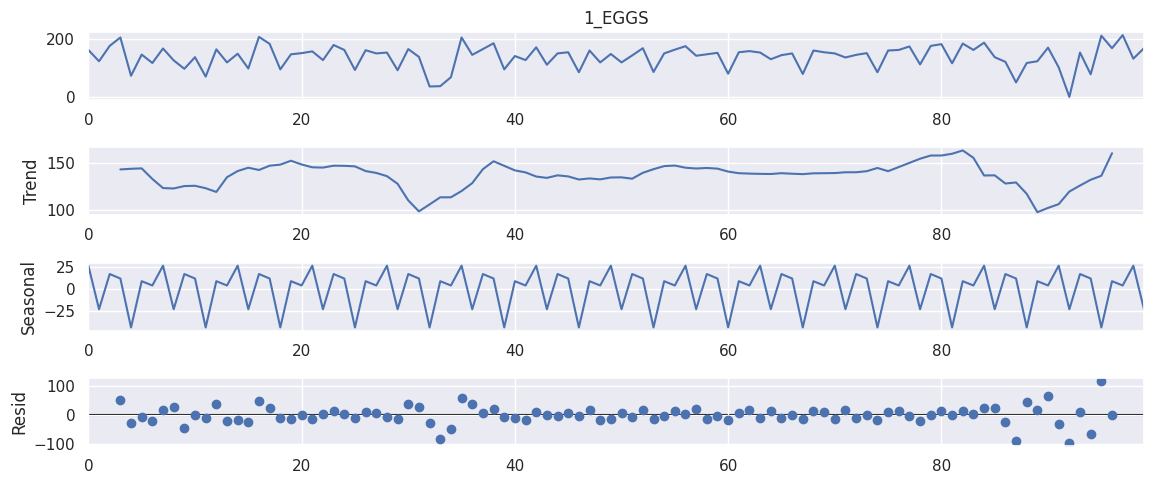

In [571]:
case = 10
tmp = df_pivot.iloc[first:last].iloc[:,case].reset_index(drop=True)
period = 7
sd = seasonal_decompose(tmp, period=period)
print(sd.resid.abs().mean())
sd.plot();

19.242712782787535


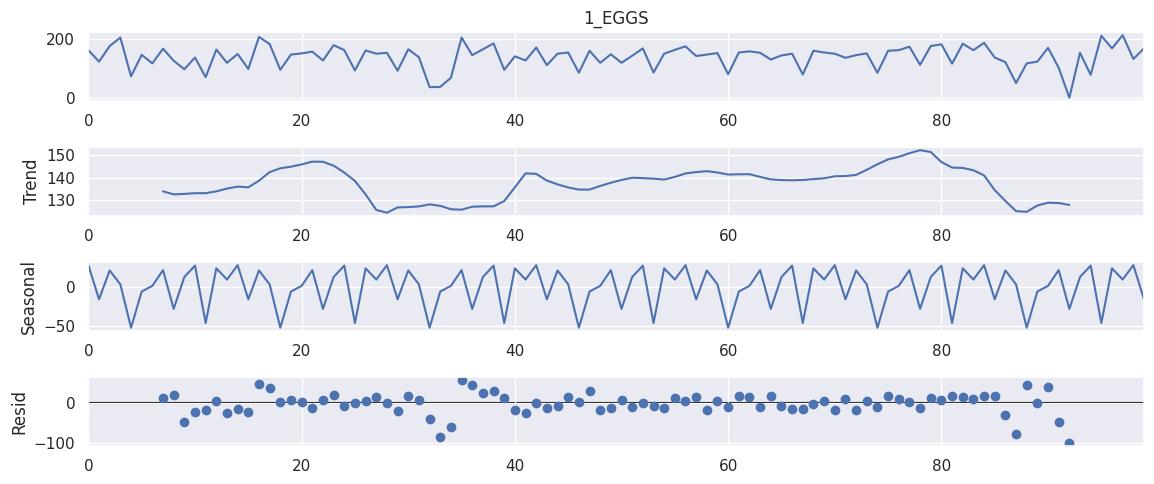

In [572]:
case = 10
tmp = df_pivot.iloc[first:last].iloc[:,case].reset_index(drop=True)
period = 14
sd = seasonal_decompose(tmp, period=period)
print(sd.resid.abs().mean())
sd.plot();

acf7:0.29752570681258994, acf14:0.3437278489412153


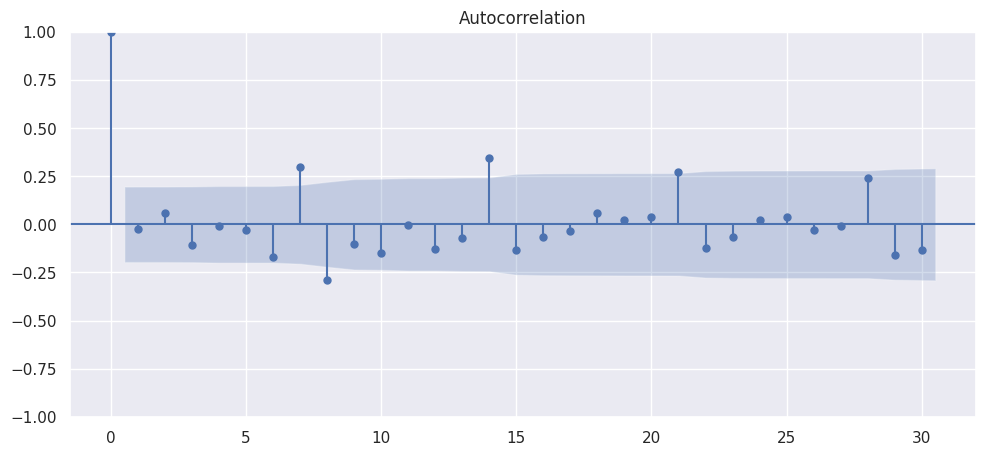

In [570]:
case = 10
tmp = df_pivot.iloc[first:last].iloc[:,case].reset_index(drop=True)
period = 30
auto_corr = acf(tmp, fft=False, nlags=30)
plot_acf(tmp, fft=False, lags=period);
print(f'acf7:{auto_corr[7]}, acf14:{auto_corr[14]}')

In [569]:
cases_14 = []
for case in range(100):
    tmp = df_pivot.iloc[first:last].iloc[:,case].reset_index(drop=True)
    period = 30
    auto_corr = acf(tmp, fft=False, nlags=30)
#     plot_acf(tmp, fft=False, lags=period);
    if np.abs(auto_corr[14]) > np.abs(auto_corr[7]):
        print('caso:', case)
        cases_14.append(case)

caso: 10
caso: 14
caso: 19
caso: 21
caso: 26
caso: 27
caso: 28
caso: 38
caso: 40
caso: 41
caso: 43
caso: 51
caso: 52
caso: 53
caso: 58
caso: 59
caso: 61
caso: 63
caso: 73
caso: 75
caso: 80
caso: 86
caso: 94
caso: 97


## Fim teste

In [580]:
down_forecast

[1, 4, 31, 34, 37, 67, 70]

Caso 70 possui previsão de queda.


<AxesSubplot:>

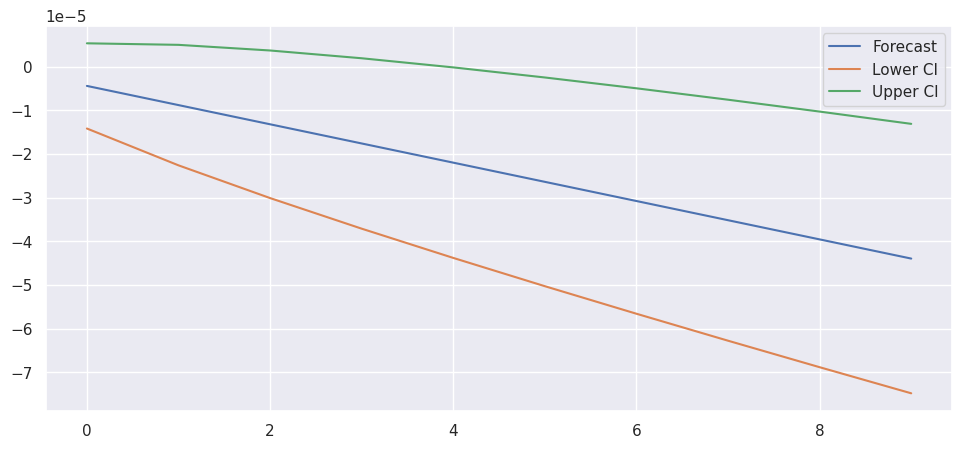

In [584]:
case = 70
array_train = df_pivot.iloc[first:last].values[:,case]
array_test = df_pivot.iloc[last:last+forecast].values[:,case]
modelo.fit(array_train)
if modelo.check_downward_forecast():
    print(f'Caso {case} possui previsão de queda.')
if modelo.check_downward_trend(array_train):
    print(f'Caso {case} possui tendência em queda.')

pred = modelo.predict()

pred.plot()

In [423]:
modelo.model.endog_index_

## Checar se o forecast tem tendencia de queda

In [ ]:
import statsmodels.api as sm

def has_downward_trend(data, seasonal_periods):
    """
    Returns True if the given time series data has a downward trend, False otherwise.
    The function considers multiple possible seasonalities specified by seasonal_periods.
    """
    # apply seasonal decomposition to the time series
    decomposition = sm.tsa.seasonal_decompose(data, model="additive", period=period)

    # extract the trend component
    trend = decomposition.trend.dropna()

    # check for a downward trend in the trend component
    if len(trend) >= 2 and np.all(np.diff(trend) < 0):
        return True

    return False

In [ ]:
forecasts = model.predict(n_periods=24, return_conf_int=True)

# extract the trend component from the forecasts
trend = sm.tsa.seasonal_decompose(forecasts[:, 0], model="additive", period=12).trend